In [7]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
# 0.01 ensures that structures from PC1 and PC2 sampling are physical
l = 0.01
u = 1-l

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)


pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   


In [2]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240905_RunWeightMCMC_Sox9_PCA_utilsV2.py'
stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')


In [6]:
esc_log_weights = load_weights(stan_directory_esc, 2500)
cnc_log_weights = load_weights(stan_directory_cnc, 2500)

esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 2500)
cnc_weights_all = cnc_weights_all.reshape(-1, 2500)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

['20240715_WeightOptimization-20240905141043_1.csv', '20240715_WeightOptimization-20240905141043_2.csv', '20240715_WeightOptimization-20240905141043_3.csv', '20240715_WeightOptimization-20240905141043_4.csv']
['20240715_WeightOptimization-20240905141800_1.csv', '20240715_WeightOptimization-20240905141800_2.csv', '20240715_WeightOptimization-20240905141800_3.csv', '20240715_WeightOptimization-20240905141800_4.csv']


(25,)

In [8]:
import matplotlib

esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'

In [9]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240905'

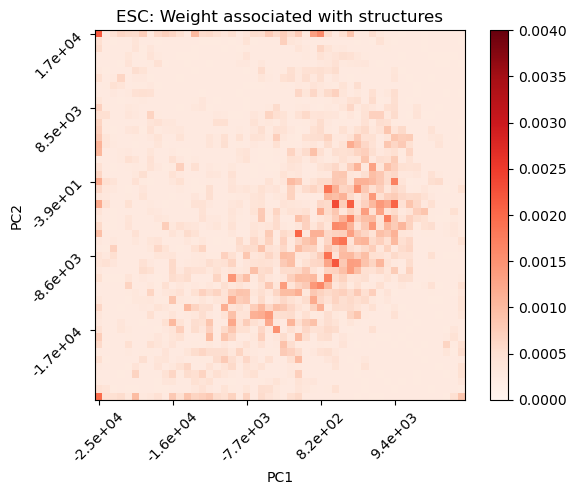

In [10]:
plt.imshow(esc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', vmin=0, vmax=0.004)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in esc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ESC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'esc_weights_50x50.png'), dpi=300, bbox_inches='tight')

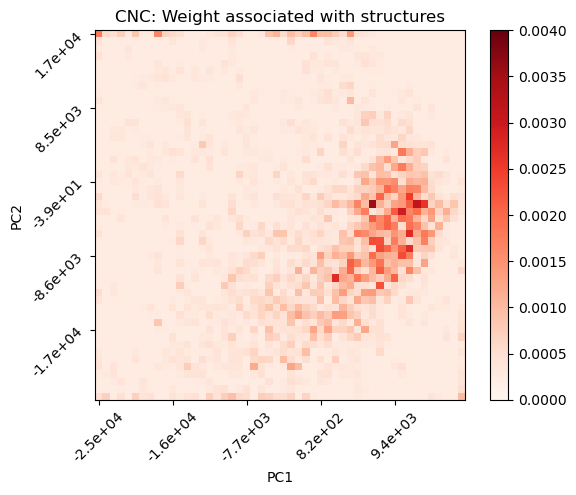

In [11]:
plt.imshow(cnc_weights_df['weight'].values.reshape(50, 50).T,
           cmap='Reds', vmin=0, vmax=0.004)
# set xticks 
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CNC: Weight associated with structures')
plt.colorbar()
plt.savefig(os.path.join(save_dir, 'cnc_weights_50x50.png'), dpi=300, bbox_inches='tight')

In [13]:
esc_weight_table = esc_weights_df['weight'].values.reshape(50, 50).T
cnc_weight_table = cnc_weights_df['weight'].values.reshape(50, 50).T

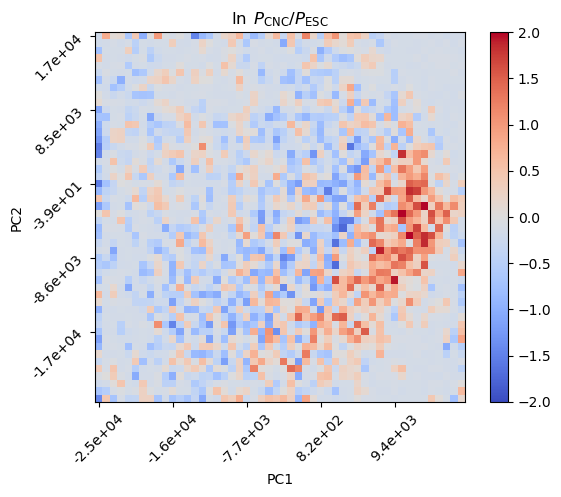

In [14]:
plt.imshow(np.log(cnc_weight_table / esc_weight_table), cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar()
xlabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()])[::10]
ylabel = np.array([f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()])[::-10]
plt.xticks(np.arange(0, 50, 10), xlabel, rotation=45)
plt.yticks(np.arange(0, 50, 10), ylabel, rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio_50x50.png'), dpi=300, bbox_inches='tight')

<Axes: xlabel='label', ylabel='entropy'>

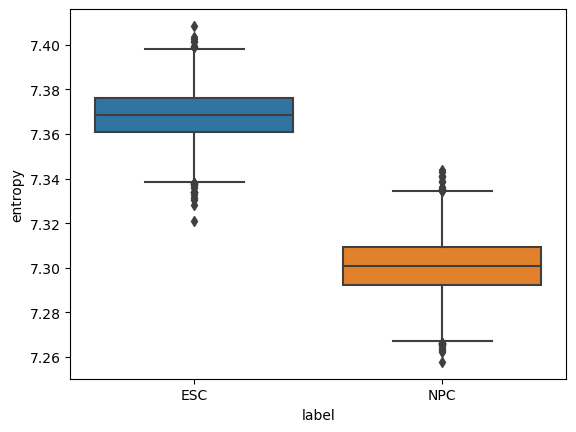

In [15]:
sns.boxplot(x='label', y='entropy', data=all_entropy_df)

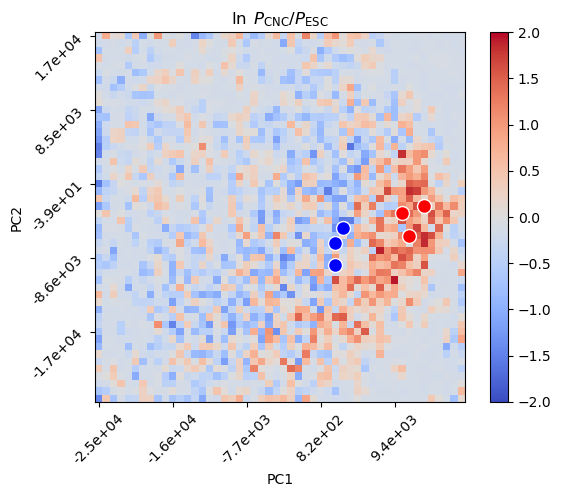

In [18]:
num_metastructures = 50

esc_weights_grid = esc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T
cnc_weights_grid = cnc_weights_df['weight'].values.reshape(num_metastructures, num_metastructures).T

diff_table = np.log(cnc_weights_grid / esc_weights_grid)

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar()
plt.xticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()][::10], rotation=45)
plt.yticks(np.arange(0, num_metastructures, 10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-10], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=100, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=100, edgecolor='white')

plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate.png'), dpi=300, bbox_inches='tight')

In [20]:
metastr_dict = {}
for i in range(2500):
    idx = (i%50, i//50)
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    metastr_dict[idx] = metastr

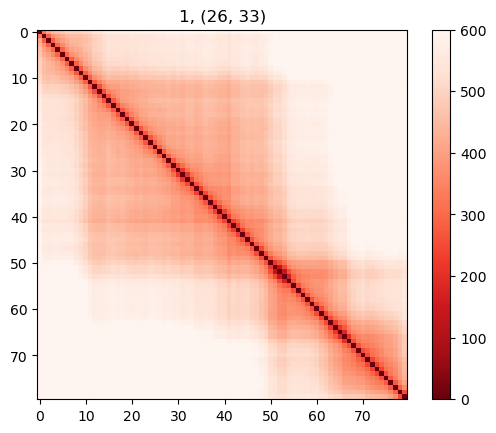

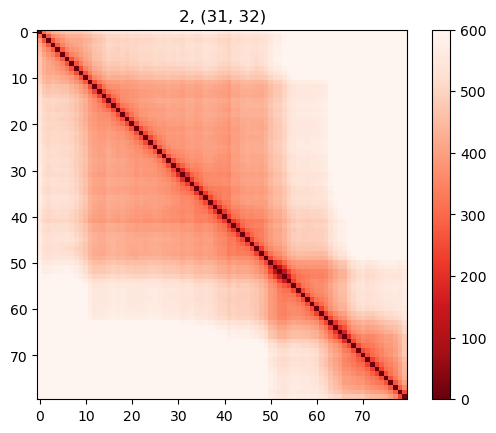

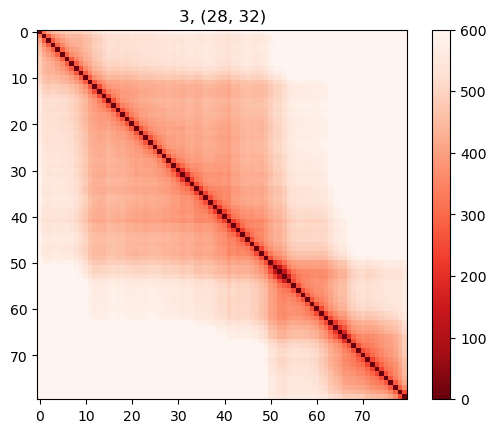

In [21]:
for i in range(3):
    plt.imshow(metastr_dict[bottom_10_indices[i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, bottom_10_indices[i]))
    plt.savefig(os.path.join(save_dir, 'bottom_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()

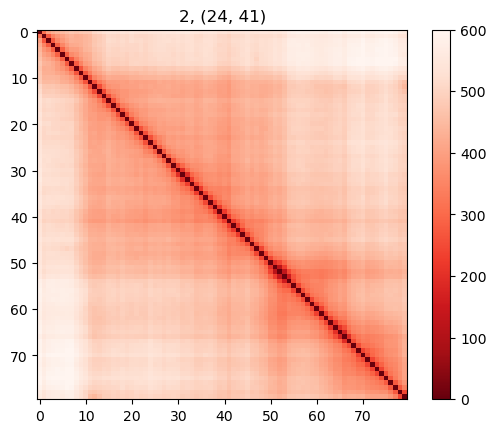

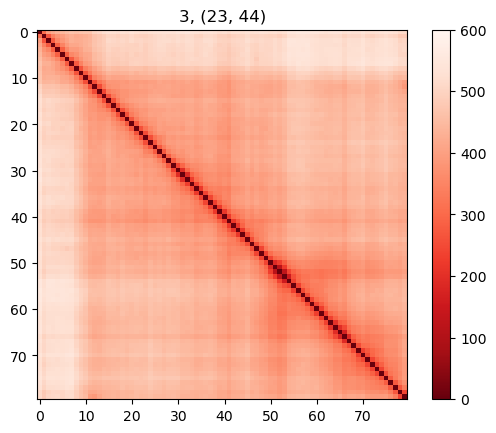

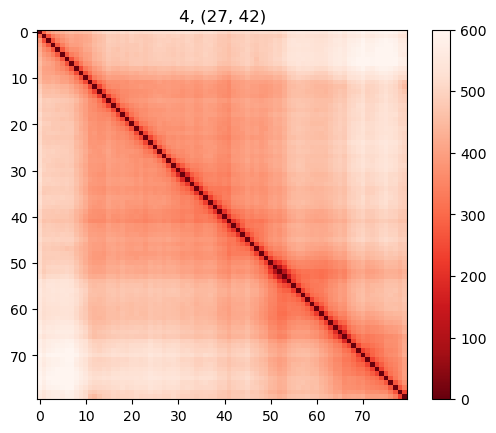

In [22]:
for i in range(1, 4):
    plt.imshow(metastr_dict[top_10_indices[-i]], cmap='Reds_r', vmax=600)
    plt.colorbar()
    plt.title('{}, {}'.format(i+1, top_10_indices[-i]))
    plt.savefig(os.path.join(save_dir, 'top_{}_metastructure.png'.format(i+1)), dpi=300, bbox_inches='tight')
    plt.show()